In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timesteps = 50
dt = 1e-3
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
        "threshold": 1.0,
        "i_offset": 0.0,
        "reset": "reset_to_v_reset",
        "dt": dt,
        "tau_mem": tau_mem,
        "tau_syn": tau_syn,
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [50]:
dims = [2, 3, 2]
# dims = [196, 25, 2]

# gains = np.array([1, 2]) * 1e0
gains = np.array([2, 1.5, 2.5]) * 1e0
np.random.seed(42)
use_loss = True

# input_spike_times = {
#     n: np.where(
#         np.random.poisson(lam=0.2, size=(timesteps - 1)).clip(0, 1).astype(int)
#     )[0].tolist()
#     for n in range(dims[0])
# }

input_spike_times = {
        k: (np.random.choice(np.arange(int(timesteps) - 1), size=5)* (1e-3 / dt)).astype(int)
        for k in range(dims[0])
    }

print(input_spike_times)
input_spikes = np.zeros((timesteps, 1, dims[0]))
for n, times in input_spike_times.items() : 
    input_spikes[times, 0, n] = 1

input_spikes = torch.from_numpy(input_spikes).float().to(device)

{0: array([38, 28, 14, 42,  7]), 1: array([20, 38, 18, 22, 10])}


In [51]:
from eventprop.models import SNN

In [52]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "mu": 1.,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type" : "eventprop",
    "reset_to_zero" : True
}


In [53]:
eventprop_model = SNN(dims, **model_config)
layers = eventprop_model.layers
for l, (layer, gain) in enumerate(zip(layers, gains)) : 
    n2, n1 = layer.weight.shape
    nu = 1. / np.sqrt(n1)
    # layer.weight.data = torch.from_numpy(np.random.normal(nu, nu, size=(n1, n2))).T.float() * gain
    layer.weight.data = torch.from_numpy(np.arange(1, n1 * n2 + 1).reshape((n1, n2)) + l * n1 * n2).T.float() 

eventprop_model.to(device)

SNN(
  (layers): RecordingSequential(
    (0): SpikingLinear_ev(2, 3)
    (1): SpikingLinear_ev(3, 2)
  )
)

In [54]:
packs = []
input = input_spikes.to(device)	
for layer in layers : 
    pack, _ = layer.manual_forward(input)
    packs.append(pack)
    input = pack[-1]

In [55]:
(inputs, Vs, V_spikes, Is, all_out_spikes) = list(zip(*packs))

In [56]:
all_spike_times = {}
for layer_id, (out_spikes, dim) in enumerate(zip(all_out_spikes, dims[1:])) : 
    all_spike_times[layer_id] = {}
    
    spike_times = torch.where(out_spikes[:, 0])
    spike_times = {
        n : spike_times[0][spike_times[1] == n].cpu().data.numpy() for n in range(dim)
    }
    spike_times
    first_spike_times = {
        n : spike_times[n][0] if len(spike_times[n]) > 0 else -1 for n in range(dim)
    }
    first_spikes_only = torch.zeros_like(out_spikes)
    for n in range(dim) : 
        if first_spike_times[n] > 0 : 
            first_spikes_only[first_spike_times[n], 0, n] = 1
    all_spike_times[layer_id]["all"] = spike_times
    all_spike_times[layer_id]["first"] = first_spike_times

In [57]:
LOSS_ALPHA = 3e-3
LOSS_TAU_0 = 5e-4
LOSS_TAU_0_INV = 1. / LOSS_TAU_0
LOSS_TAU_1 = 6.4e-3
LOSS_DT = 1e-3
LOSS_DT_TAU_0_RATIO = LOSS_DT / LOSS_TAU_0
LOSS_DT_TAU_1_RATIO = LOSS_DT / LOSS_TAU_1
LOSS_ALPHA_TAU_1_RATIO = LOSS_ALPHA / LOSS_TAU_1

In [58]:
if False :
    labels = 0
    first_spike_errors = {
        n : 0 for n in range(dims[1])
    }
    t_l = first_spike_times[labels]
    sum0 = 0
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 : 
            sum0 += np.exp(-(first_spike_times[n] ) * LOSS_DT_TAU_0_RATIO)
        
    label_error = LOSS_TAU_0_INV * (1 - np.exp(-t_l * LOSS_DT_TAU_0_RATIO) / sum0) + LOSS_ALPHA_TAU_1_RATIO * np.exp(t_l * LOSS_DT_TAU_1_RATIO)
    first_spike_errors[labels] += label_error
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 and labels != n: 
            first_spike_errors[n] = -LOSS_TAU_0_INV * (1 / sum0) * np.exp(-(first_spike_times[n]) * LOSS_DT_TAU_0_RATIO) 
else : 
    label = 0
    first_spike_errors = {
        n : 1 if n == label else -1 for n in range(dims[-1])
    }

In [59]:
first_spike_grads = torch.cat(list({
    n : spikes * error for spikes, (n, error) in zip(first_spikes_only.split(1, dim=-1), first_spike_errors.items())
}.values()), -1)

In [60]:
bw_packs = []
grads = first_spike_grads
for layer, pack in zip(layers[::-1], packs[::-1]) :         
    bw_pack = layer.manual_backward(grads, pack)
    grads = bw_pack[0]
    bw_packs.append(bw_pack)


In [61]:
grad_inputs, grad_weights, lVs, lIs = list(zip(*bw_packs[::-1]))

In [62]:
all_spike_times['stim'] = {}
all_spike_times['stim']['all'] = input_spike_times
all_spike_times = dict(sorted(all_spike_times.items(), key=lambda x : x != 'stim'))

In [63]:
sources = ['stim'] + list(range(len(layers)))

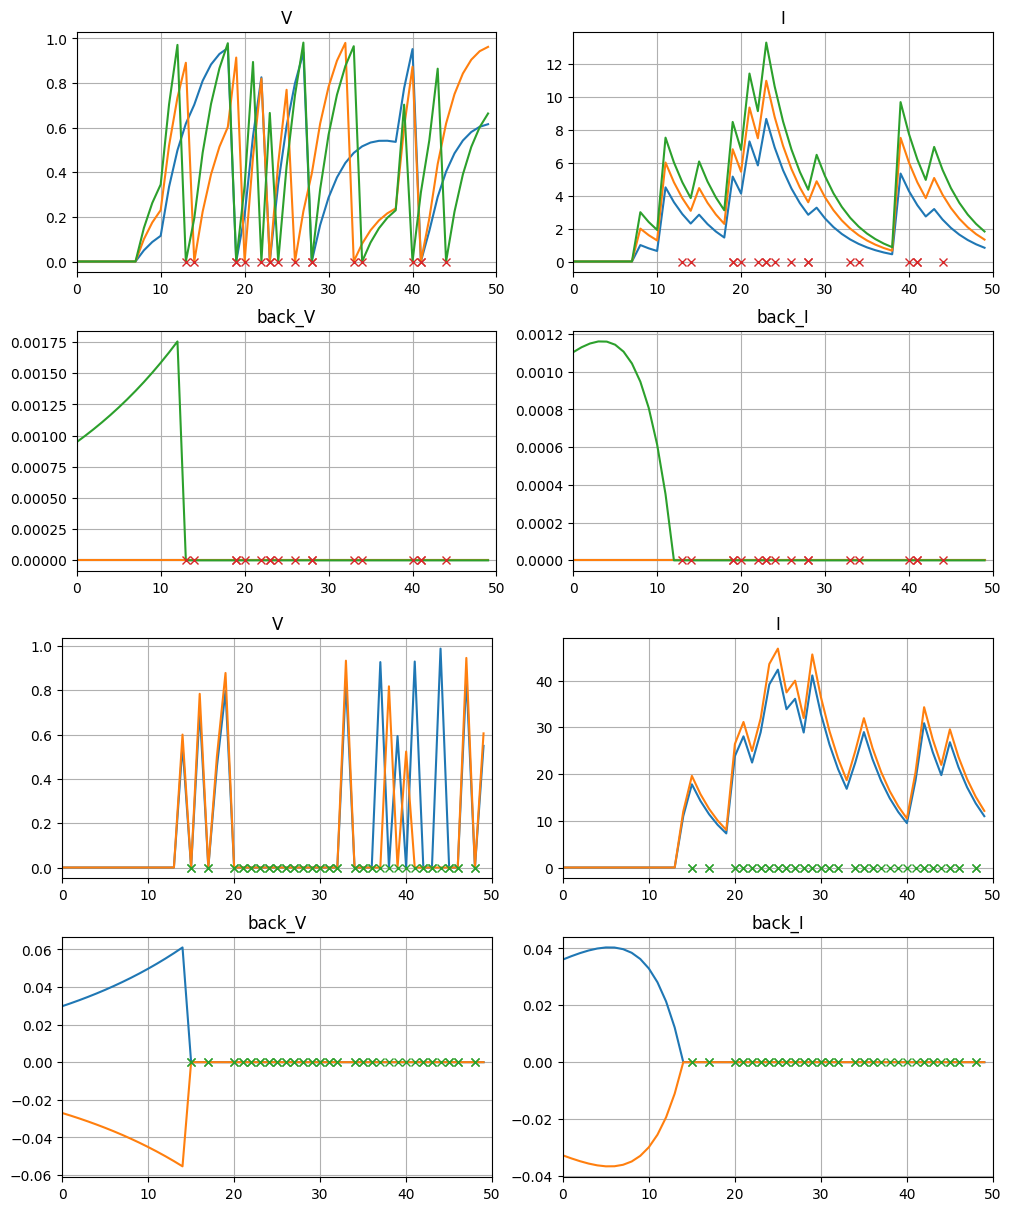

In [66]:
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for subfig, V, I, lV, lI, out_spike_source, in_spike_source, dim_out, dim_in in zip(
    subfigs,
    Vs,
    Is,
    lVs,
    lIs,
    sources[1:],
    sources[:-1],
    dims[1:],
    dims[:-1],
):
    axs = subfig.subplots(2, 2)
    for ax, data, title in zip(
        axs.T.flatten(), [V, lV, I, lI], ["V", "back_V", "I", "back_I"]
    ):
        # for n in range(dim_out) :
        ax.plot(data[:, 0].cpu().data.numpy())

        # print(in_spike_source, out_spike_source)
        out_spike_times = all_spike_times[out_spike_source]["all"]
        in_spike_times = all_spike_times[in_spike_source]["all"]

        ax.plot(
            np.concatenate(list(out_spike_times.values())),
            np.zeros_like(np.concatenate(list(out_spike_times.values()))),
            "x",
        )
        # ax.plot(
        #     np.concatenate(list(in_spike_times.values())),
        #     np.zeros_like(np.concatenate(list(in_spike_times.values()))),
        #     "+",
        #     color='black'
        # )

        ax.set_title(title)
        ax.grid(visible=True)
        ax.set_xlim(0, timesteps)

In [65]:
[g.cpu().data.numpy() for g in grad_weights]

[array([[[ 0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00],
         [-5.2204600e-06, -3.0718847e-06]]], dtype=float32),
 array([[[ 0.0000000e+00,  0.0000000e+00, -6.1022125e-05],
         [ 0.0000000e+00,  0.0000000e+00,  5.5401655e-05]]], dtype=float32)]

In [23]:
all_spike_times

{0: {'all': {0: array([25, 30, 36, 41, 45]),
   1: array([12, 21, 24, 28, 34, 42, 49]),
   2: array([22, 24, 26, 29, 36, 45]),
   3: array([11, 16, 21, 25, 31, 39, 43, 47]),
   4: array([12, 20, 23, 26, 29, 37, 44]),
   5: array([ 8, 16, 23, 26, 33, 43, 49]),
   6: array([21, 24, 27, 31, 37, 41, 44, 49]),
   7: array([11, 20, 25, 30, 34, 40, 44, 49]),
   8: array([10, 15, 22, 25, 29, 36, 40, 43, 46]),
   9: array([22, 26, 31, 37, 43, 48])},
  'first': {0: 25,
   1: 12,
   2: 22,
   3: 11,
   4: 12,
   5: 8,
   6: 21,
   7: 11,
   8: 10,
   9: 22}},
 1: {'all': {0: array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
          28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49]),
   1: array([10, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29,
          30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
          47, 48, 49])},
  'first': {0: 11, 1: 10}},
 'stim': {'all': {0: array([38])

In [24]:
lIs[0].squeeze()

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7671,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7425,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7003,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.6357,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5422,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4121,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2355,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

In [25]:
lVs[1].squeeze().cpu().data.numpy()[::-1]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [26]:
lIs[1].squeeze().cpu().data.numpy()[::-1]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [27]:
grad_weights[1].item()#, grad_weights[0].cpu().data.numpy()


RuntimeError: a Tensor with 20 elements cannot be converted to Scalar

In [ ]:
grad_weights

(tensor([[[ 0.0000,  0.0000, -0.0540]]], device='cuda:0',
        grad_fn=<SubBackward0>),
 tensor([[[-0.0015]]], device='cuda:0', grad_fn=<SubBackward0>))

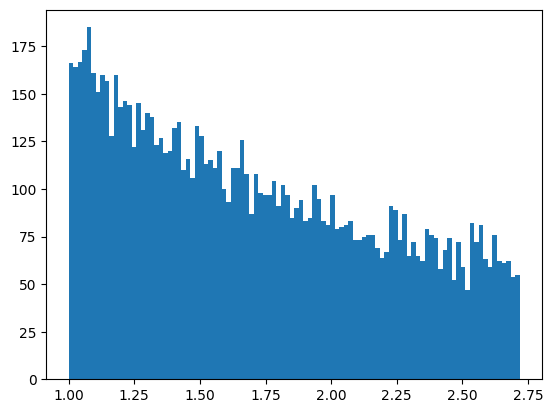

In [ ]:
plt.hist([np.exp(np.random.rand()) for _ in range(10000)], bins=100);

In [ ]:
np.random.uniform(np.log(0.1), np.log(1e-3))

-2.4504551757146054

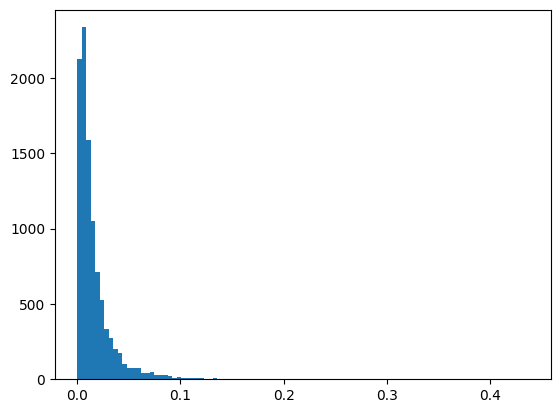

In [ ]:
plt.hist(np.exp(np.random.normal(np.log(1e-2), 1, size=10000)), bins=100);
# plt.loglog()

In [ ]:
np.log(1e-2)

-4.605170185988091

In [ ]:
unique_times = np.unique(np.concatenate(list(all_spike_times[0]['all'].values())), return_counts=True)[1]
unique_times.sort()
unique_times

array([1, 1, 1, 1, 1, 1, 1])

In [ ]:
offline_times = all_spike_times[0]['all']

: 